In [ ]:
!pip3 uninstall --yes torch torchaudio torchvision torchtext torchdata
!pip3 install torch torchaudio torchvision torchtext torchdata

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pickle
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import math
from google.colab import drive, files

import torch
from torch.nn import functional as F
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import StepLR
from torch.nn import TransformerEncoder, TransformerDecoder

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
drive.mount('/content/drive')

In [ ]:
pkl_file_path = "/content/drive/MyDrive/Research: Computational Cardiovascular Models (1)/Computational Cardiac Models: Point RNN/Fall 2024: ML Models/Data Preparation/processed_fibers_longer_fibers.pkl"

file_path = "/content/drive/MyDrive/💜✨🌺🦋🌸 Fall 2024: ML Models/Data Preparation/processed_fibers.pkl"

with open(pkl_file_path, "rb") as f:
    fibers = pickle.load(f)

In [ ]:
train_fibers, test_fibers = train_test_split(fibers, test_size=0.2, random_state=42)

In [ ]:
class FiberDataset(Dataset):
    def __init__(self, fiber_list, max_seq_len):
        self.fiber_list = fiber_list
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.fiber_list)

    def __getitem__(self, idx):
        fiber = self.fiber_list[idx]
        seq_len = fiber.shape[0]

        # Padding
        padding_len = self.max_seq_len - seq_len
        padding = torch.full((padding_len, 5), -1.0) # Use -1 for padding, adjust if needed
        padded_fiber = torch.cat([fiber, padding], dim=0)

        # Attention Mask (True for padded values)
        mask = torch.zeros(self.max_seq_len, dtype=torch.bool)
        mask[seq_len:] = True

        return padded_fiber, mask, seq_len # Return the original sequence length as well

In [ ]:
train_dataset = FiberDataset(train_fibers, 591)
test_dataset = FiberDataset(test_fibers, 591)

torch.manual_seed(42)
train_subset, val_subset = random_split(train_dataset, [0.9, 0.1])

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=12, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=12, pin_memory=True)

Batch size: 128
Sequence length: 591
Feature dimension: 5
Mask shape: torch.Size([128, 591])
Sequence lengths: tensor([203,  71, 112, 106, 190, 117,  71, 135, 319, 229,  79, 140, 235, 227,
         63,  43, 154, 115, 104,  66, 293,  83, 344,  91, 323,  55, 161, 173,
        258, 196, 144, 241, 194,  68,  52, 107, 276, 111, 478, 121, 116, 285,
        486, 122, 107, 295, 296,  95, 221, 419, 282, 164,  92,  41, 104, 112,
        321, 231, 133, 164, 295,  94, 182, 109,  56,  66, 237,  64, 112, 105,
         67, 570, 229, 318, 280,  79, 206, 148, 373, 483, 251,  62, 179, 301,
        228, 345, 212,  97,  99,  70, 494,  99, 136,  80, 149, 155, 181, 198,
        118,  53,  66, 242, 288, 129, 240, 174,  64, 205, 306,  71, 229,  82,
        143,  75,  87,  92, 414, 207, 108, 141, 268, 204,  94, 245, 233, 104,
        522, 129])


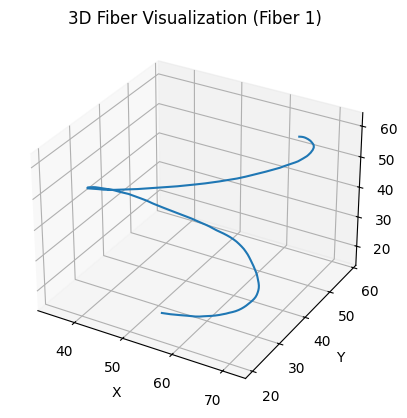

Example mask (first fiber): tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, 

In [ ]:
import matplotlib.pyplot as plt
data_iter = iter(train_loader)
x, mask, seq_lens = next(data_iter)
fiber_index = 0
fiber = x[fiber_index, :seq_lens[fiber_index], :] # Slice up to the original sequence length

print("Batch size:", x.shape[0])
print("Sequence length:", x.shape[1])
print("Feature dimension:", x.shape[2])
print("Mask shape:", mask.shape)
print("Sequence lengths:", seq_lens)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(fiber[:, 0], fiber[:, 1], fiber[:, 2])  # x,y,z coordinates
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title(f"3D Fiber Visualization (Fiber {fiber_index + 1})")
plt.show()

# Verify that the mask correctly identifies padded regions
print("Example mask (first fiber):", mask[0])
print("Padded values (first fiber):", x[0, mask[0], :]) # Should be all -1s (or your padding value)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=600):
        super().__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.encoding[:, :seq_len].to(x.device)

class FiberAutoencoder(nn.Module):
    def __init__(self, input_dim=5, d_model=128, nhead=8, num_layers=4, max_seq_len=600, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.input_projection = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=512, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward=512, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers)

        self.output_projection = nn.Linear(d_model, input_dim)

    def forward(self, x, mask):
        """
        Args:
            x: Tensor of shape (batch_size, max_seq_len, input_dim)
            mask: Padding mask of shape (batch_size, max_seq_len), True for padding values
        Returns:
            Reconstructed sequence of shape (batch_size, max_seq_len, input_dim)
        """
        # Input projection and positional encoding
        x = self.input_projection(x)
        x = self.positional_encoding(x)

        # Encoder
        memory = self.encoder(x, src_key_padding_mask=mask)

        # Decoder (auto-regressive reconstruction)
        output = self.decoder(memory, memory, tgt_key_padding_mask=mask, memory_key_padding_mask=mask) # need to think about this for a bit

        # Output projection
        output = self.output_projection(output)
        return output

In [ ]:
def masked_mse_loss(pred, target, mask):
    """
    Args:
        pred: Predicted sequence of shape (batch_size, max_seq_len, input_dim)
        target: Ground truth sequence of shape (batch_size, max_seq_len, input_dim)
        mask: Padding mask of shape (batch_size, max_seq_len), True for padding
    Returns:
        Mean squared error loss, ignoring padding values.
    """
    mask = ~mask.unsqueeze(-1)  # Invert mask for valid values
    mse = F.mse_loss(pred, target, reduction='none')
    mse = mse * mask
    return mse.sum() / mask.sum()

In [ ]:
input_dim = 5  # Number of features: [x, y, z, helical_angle, transmural_depth]
d_model = 128
nhead = 8
num_layers = 4
max_seq_len = 591
dropout = 0.1
batch_size = 128
learning_rate = 1e-4
weight_decay = 1e-5
epochs = 50

model = FiberAutoencoder(input_dim=input_dim, d_model=d_model, nhead=nhead, num_layers=num_layers, max_seq_len=max_seq_len, dropout=dropout).cuda()
criterion = nn.MSELoss(reduction="none")  # Masked MSE will be applied in the loop
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, min_lr=1e-8)

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    best_val_loss = float("inf")

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        model.train()
        train_loss = 0.0
        for padded_fiber, mask, _ in tqdm(train_loader, desc="Training"):
            padded_fiber, mask = padded_fiber.cuda(), mask.cuda()

            # Forward pass
            optimizer.zero_grad()
            outputs = model(padded_fiber, mask)

            mask = ~mask.unsqueeze(-1)  # Invert mask for valid points
            loss = criterion(outputs, padded_fiber)  # Shape: (batch_size, max_seq_len, input_dim)
            loss = (loss * mask).sum() / mask.sum()  # Masked MSE
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        print(f"Training Loss: {train_loss:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for padded_fiber, mask, _ in tqdm(val_loader, desc="Validation"):
                padded_fiber, mask = padded_fiber.cuda(), mask.cuda()

                # Forward pass
                outputs = model(padded_fiber, mask)

                # Calculate loss
                mask = ~mask.unsqueeze(-1)
                loss = criterion(outputs, padded_fiber)
                loss = (loss * mask).sum() / mask.sum()
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Validation Loss: {val_loss:.4f}")
        if ( (epoch + 1) % 5 == 0) and ((epoch + 1) >= 5):
            torch.save(model.state_dict(), f"Transformer_autoencoder_epoch_{epoch+1}_version_2.pth")

        scheduler.step(val_loss)
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}\n\n")

    return model

In [ ]:
trained_model = train_model(model, train_loader, val_loader, optimizer, criterion, epochs)

Epoch 1/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 2831.4081


Validation:   0%|          | 0/253 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Validation: 100%|██████████| 253/253 [00:22<00:00, 11.07it/s]


Validation Loss: 747.3220
Learning Rate: 0.000100


Epoch 2/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.87it/s]


Training Loss: 324.9904


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s]


Validation Loss: 88.8959
Learning Rate: 0.000100


Epoch 3/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.87it/s]


Training Loss: 35.3671


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.11it/s]


Validation Loss: 8.3916
Learning Rate: 0.000100


Epoch 4/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 4.8687


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.13it/s]


Validation Loss: 3.3481
Learning Rate: 0.000100


Epoch 5/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 1.7288


Validation: 100%|██████████| 253/253 [00:23<00:00, 10.72it/s]


Validation Loss: 1.3051
Learning Rate: 0.000100


Epoch 6/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 1.1206


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.15it/s]


Validation Loss: 1.2088
Learning Rate: 0.000100


Epoch 7/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.8601


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s]


Validation Loss: 1.1386
Learning Rate: 0.000100


Epoch 8/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.7078


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.12it/s]


Validation Loss: 0.9458
Learning Rate: 0.000100


Epoch 9/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.6031


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s]


Validation Loss: 0.5020
Learning Rate: 0.000100


Epoch 10/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.5240


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s]


Validation Loss: 0.5950
Learning Rate: 0.000100


Epoch 11/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.4621


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s]


Validation Loss: 0.4442
Learning Rate: 0.000100


Epoch 12/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.4178


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.09it/s]


Validation Loss: 0.7386
Learning Rate: 0.000100


Epoch 13/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.3777


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s]


Validation Loss: 0.4104
Learning Rate: 0.000100


Epoch 14/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.3452


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s]


Validation Loss: 0.6079
Learning Rate: 0.000100


Epoch 15/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.87it/s]


Training Loss: 0.3176


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s]


Validation Loss: 0.5465
Learning Rate: 0.000100


Epoch 16/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.2933


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.18it/s]


Validation Loss: 0.5068
Learning Rate: 0.000100


Epoch 17/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.2693


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.17it/s]


Validation Loss: 0.3776
Learning Rate: 0.000100


Epoch 18/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.2551


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s]


Validation Loss: 0.5090
Learning Rate: 0.000100


Epoch 19/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.2368


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.13it/s]


Validation Loss: 0.6012
Learning Rate: 0.000100


Epoch 20/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.2209


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.15it/s]


Validation Loss: 0.4795
Learning Rate: 0.000100


Epoch 21/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.2092


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.13it/s]


Validation Loss: 0.4126
Learning Rate: 0.000010


Epoch 22/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1567


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.12it/s]


Validation Loss: 0.5031
Learning Rate: 0.000010


Epoch 23/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1537


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.15it/s]


Validation Loss: 0.6208
Learning Rate: 0.000010


Epoch 24/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.1499


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s]


Validation Loss: 0.6264
Learning Rate: 0.000010


Epoch 25/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1462


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.12it/s]


Validation Loss: 0.6162
Learning Rate: 0.000001


Epoch 26/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1409


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.11it/s]


Validation Loss: 0.6472
Learning Rate: 0.000001


Epoch 27/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.1404


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s]


Validation Loss: 0.6834
Learning Rate: 0.000001


Epoch 28/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1398


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.09it/s]


Validation Loss: 0.6688
Learning Rate: 0.000001


Epoch 29/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1392


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.13it/s]


Validation Loss: 0.6797
Learning Rate: 0.000000


Epoch 30/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1384


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s]


Validation Loss: 0.6719
Learning Rate: 0.000000


Epoch 31/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.1383


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.15it/s]


Validation Loss: 0.6829
Learning Rate: 0.000000


Epoch 32/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1383


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.13it/s]


Validation Loss: 0.6828
Learning Rate: 0.000000


Epoch 33/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1381


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s]


Validation Loss: 0.6706
Learning Rate: 0.000000


Epoch 34/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1381


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s]


Validation Loss: 0.6791
Learning Rate: 0.000000


Epoch 35/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.1380


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.15it/s]


Validation Loss: 0.6789
Learning Rate: 0.000000


Epoch 36/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1381


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.10it/s]


Validation Loss: 0.6799
Learning Rate: 0.000000


Epoch 37/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1381


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.13it/s]


Validation Loss: 0.6804
Learning Rate: 0.000000


Epoch 38/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1382


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.06it/s]


Validation Loss: 0.6791
Learning Rate: 0.000000


Epoch 39/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1380


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.16it/s]


Validation Loss: 0.6790
Learning Rate: 0.000000


Epoch 40/50


Training: 100%|██████████| 2271/2271 [13:12<00:00,  2.86it/s]


Training Loss: 0.1380


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.12it/s]


Validation Loss: 0.6797
Learning Rate: 0.000000


Epoch 41/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1380


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.14it/s]


Validation Loss: 0.6762
Learning Rate: 0.000000


Epoch 42/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1381


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.10it/s]


Validation Loss: 0.6791
Learning Rate: 0.000000


Epoch 43/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1380


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.11it/s]


Validation Loss: 0.6806
Learning Rate: 0.000000


Epoch 44/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1381


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.07it/s]


Validation Loss: 0.6801
Learning Rate: 0.000000


Epoch 45/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1381


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.09it/s]


Validation Loss: 0.6793
Learning Rate: 0.000000


Epoch 46/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1380


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.12it/s]


Validation Loss: 0.6800
Learning Rate: 0.000000


Epoch 47/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1380


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.11it/s]


Validation Loss: 0.6774
Learning Rate: 0.000000


Epoch 48/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1380


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.04it/s]


Validation Loss: 0.6763
Learning Rate: 0.000000


Epoch 49/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1380


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.06it/s]


Validation Loss: 0.6816
Learning Rate: 0.000000


Epoch 50/50


Training: 100%|██████████| 2271/2271 [13:13<00:00,  2.86it/s]


Training Loss: 0.1381


Validation: 100%|██████████| 253/253 [00:22<00:00, 11.08it/s]

Validation Loss: 0.6786
Learning Rate: 0.000000




In [ ]:
save_path = '/content/Transformer_autoencoder_version_2.pth'
torch.save(trained_model.state_dict(), save_path)

In [ ]:
files.download(save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>